In [1]:
# Necessary libraries
import numpy as np
import pandas as pd
import re
import time
import random
import csv
from collections import OrderedDict

# extracting HTML from URL
import requests
# extracting text from HTML
import justext
# calculating SMOG grade
import textstat
# refactoring URL
from urllib.request import urlretrieve
import tldextract
# reading PDF 
import PyPDF2
# getting current time and date
from datetime import datetime
# running function on schedule
import schedule
# creating directory
from pathlib import Path
# getting publication date of the website
from htmldate import find_date

# Selenium web scrapping 
from selenium import webdriver 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

# Rank-Biased Overlap analysis
import rbo
# Jaccard-Needham dissimilarity 
import distance
# Kendall’s tau
import scipy.stats as stats

# Graphs
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from lib.tools import LogoutGoogle, Search, RBO, JACCARD, KENDAL, Plot, CalculatePersonalization, CalculateFairness

# FIX BUGS

In [16]:
def LoginGoogle(email, password):
    # new driver for a new account (signed-in search)
    # install HONCode Toolbar Chrome Extension
    hon_extension_path = 'src/extension_hon.crx'
    cookie_extension_path = 'src/extension_cookie.crx'
    options = Options()
    options.add_argument("--disable-dev-shm-usage")
    options.add_experimental_option('prefs', {'intl.accept_languages': 'en,en_UK'}) # 'en,en_UK'  'fr_FR'
    options.add_extension(hon_extension_path)
    options.add_extension(cookie_extension_path)
    
    browser = webdriver.Chrome(ChromeDriverManager().install(), desired_capabilities=None, options=options)

    # log in using stackoverflow.com  or soundcloud.com or pinterest.com   

    browser.get('https://www.pinterest.com/')
    time.sleep(3)
    try:
        browser.find_element_by_css_selector("button[class='RCK Hsu USg Vxj aZc Zr3 hA- GmH adn a_A gpV hNT iyn BG7 gn8 L4E kVc']").click()
    except:
        pass
    try:
        browser_logout.find_element_by_css_selector("button[class='RCK Hsu USg F10 xD4 fZz hUC GmH adn a_A gpV hNT iyn BG7 gn8 L4E kVc']").click()
    except:
        pass
# TODO    
#     try:
#         browser.find_element_by_xpath('//*[@id="__PWS_ROOT__"]/div[1]/div[2]/div/div/div[1]/div[1]/div[2]/div[3]/button').click()
#     except:
#         pass
#     try:
#         browser.find_element_by_xpath('//*[@id="__PWS_ROOT__"]/div[1]/div[2]/div/div/div[3]/div[1]/div[1]/div[2]/div[2]/button').click()
#     except:
#         pass
#     try:
#         browser.find_element_by_xpath('//*[@id="__PWS_ROOT__"]/div[1]/div[2]/div/div/div[1]/div/div[4]/button[2]').click()
#     except:
#         pass
#     try:
#         browser.find_element_by_xpath('//*[@id="__PWS_ROOT__"]/div[1]/div[2]/div/div/div[1]/div/div[2]/div/button[2]').click()
#     except:
#         pass
#     try:
#         browser.find_element_by_xpath('//*[@id="__PWS_ROOT__"]/div[1]/div[3]/div/div/div[3]/div[1]/div[1]/div[2]/div[1]').click()
#     except:
#         pass
    
    browser.find_element_by_xpath('//*[@id="googleConnectButton"]').click()
    
    
    
    time.sleep(3)
    window_before = browser.window_handles[0]
    window_after = browser.window_handles[1]
    browser.switch_to_window(window_after)
    
    time.sleep(3)
    browser.find_element_by_xpath('//*[@id="identifierId"]').send_keys(email + Keys.ENTER) 
    time.sleep(3)
    browser.find_element_by_xpath('//input[@type="password"]').send_keys(password + Keys.ENTER)
    
    time.sleep(3)
    browser.switch_to_window(window_before)
    
    return(browser)

In [10]:
def LogoutGoogle():
    # new driver for signed-out search
    # install HONCode Toolbar Chrome Extension
    packed_extension_path = 'src/extension_hon.crx'
    options = Options()
    options.add_experimental_option('prefs', {'intl.accept_languages': 'en,en_UK'}) # 'en,en_UK'  'fr_FR'
    options.add_extension(packed_extension_path)
    browser = webdriver.Chrome(ChromeDriverManager().install(), desired_capabilities=None, options=options)
    browser.get('https://www.google.com/history/optout?cb=1&hl=en&continue=https%3A%2F%2Fconsent.google.com%2Fui%2F%3Fcontinue%3Dhttps%3A%2F%2Fwww.google.com%2Fsearch%3Fsource%253Dhp%2526ei%253D-Q9VXriOKoHeas2YofAO%2526q%253DSoftware%252Btesting%26origin%3Dhttps%3A%2F%2Fwww.google.com%26if%3D1%26wp%3D71%26gl%3DFR%26hl%3Den%26pc%3Ds%23controls')
    browser.find_element_by_xpath('/html/body/div/div[1]/div[2]/div/table/tbody/tr/td[2]/form/button/div').click()
    return(browser)

In [77]:
def ScrollAndRead(browser, window_size, read_time):    
    length = int(browser.execute_script("return document.body.scrollHeight") / window_size) - 2
    if length <= 0:
        time.sleep(read_time / 2)
        browser.execute_script("window.scrollTo(0, window.scrollY + {0})".format(window_size * 2))
        time.sleep(read_time / 2)
    else:    
        for i in range(length):  
            time.sleep(read_time / length)
            browser.execute_script("window.scrollTo(0, window.scrollY + {0})".format(window_size))

In [181]:
random_state = 42

In [190]:
# PROTOCOL users simulated behavior
def SearchAndSave(
           browser, # logged-in with specific user behavior
           user, #first_hon_click, first_non_click, time_click, readability_click, no_click, average_click
           data='data/queries2019_400.csv', # path to queries
           max_num_res=8, # number of results
           ):
    
    # global varaible in order to users search same queries in the same order. Incremented every day
    global random_state    
    
    # get all queries and choose which to search
    queries_all = pd.read_csv(data, sep=',')  
    queries_today = np.asarray(queries_all.iloc[random_state:random_state+1]).flatten()
#     queries_today = []
#     for column in ['HowTo', 'WhatIS', 'CLEF2018', 'CLEF2016', 'Symptoms', 'Diseases', 'CLEF2014', 'CLEF2013']:
#         query_today = queries_all[column].dropna().sample(n=1, random_state=random_state).item()
#         queries_today.append(query_today)
    random.Random(random_state).shuffle(queries_today)
    
    
    #parameters and variables
    dict_results = {  "QUERY":[],
                      "RANK": [],
                      "URL": [],
                      'HON': [],
                      'SMOG': [],
                      'PUBLICATION_DATE': [],
                      'CLICKS&TIME': [],
                             } 
    window_size = 540 # size of scrolling window
    read_time = 5 # this value should be 60-300 # change later
    wait_time = 5 # this value should be < 60 # change later
    carry_over_time= 660
    url_probabilities = [0.32, 0.25, 0.18, 0.11, 0.07, 0.04, 0.02, 0.01 ] # average statistic on clickimg google results
    
    # search for today queries
    for query in queries_today:  
        
       
        
        #query = 'how to reduce swelling'  ### remove later on
        #query = 'depression and abdominal cramping'  ### remove later on

        # start counting time for one search, which should be at least 11 min 
        start_time = time.time()

        # find all elements provided on google search results 
        browser.get("https://google.com") 
        browser.find_element_by_xpath("//input[@name='q']").send_keys(query + Keys.ENTER)
        
        time.sleep(wait_time) ### wait to upload HON-labels
        browser.execute_script("window.scrollTo(0, window.scrollY + {0})".format(2 * window_size)) 
        
        # get number of google results 
        num_res_google = browser.find_element_by_xpath('//*[@id="result-stats"]').text
        try:
            num_res_int = int(re.search('About (.*) results', num_res_google).group(1).replace(',', ''))
        except:
            try:
                num_res_int = int(re.search('(.*) results', num_res_google).group(1).replace(',', ''))
            except:
                pass
        
        # get date and time of query search
        daytime_now = datetime.now().strftime("%H:%M:%S")   
        
        # reset variables
        num_res=0
        search_results = []
        first_hon_result = None
        first_non_result = None    
        elements = browser.find_elements_by_class_name('rc')
        try:
            first_element = browser.find_element_by_css_selector("div[class='g mnr-c g-blk']")
            temp1 = first_element.find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').get_attribute('href')
            temp2 = first_element.find_element_by_css_selector('div[target="_blank"]').get_attribute('title')
            try:
                temp3 = first_element.find_element_by_css_selector("div[class='s']").find_element_by_css_selector("span[class='f']").text
                temp3 = datetime.strptime(temp3, '%b %d, %Y -').strftime('%Y-%m-%d')
            except:
                try:
                    temp3 = first_element.find_element_by_css_selector("div[class='s']").find_element_by_css_selector("div[class='dhIWPd f']").text
                    temp3 = re.search('- (.*) - C', temp3).group(1)+'-06-15'
                except:
                    temp3 = None   
            search_results.append([temp1, temp2, temp3])
            num_res+=1
            if temp2=='HONcode certified':
                first_hon_result = first_element.find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').find_element_by_css_selector('h3')
            else:
                first_non_result = first_element.find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').find_element_by_css_selector('h3')
        except:
            try:
                first_element = browser.find_elements_by_class_name('g')[0]
                temp1 = first_element.find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').get_attribute('href')
                temp2 = first_element.find_element_by_css_selector('div[target="_blank"]').get_attribute('title')
                
                try:
                    temp3 = first_element.find_element_by_css_selector("div[class='s']").find_element_by_css_selector("span[class='f']").text
                    temp3 = datetime.strptime(temp3, '%b %d, %Y -').strftime('%Y-%m-%d')
                except:
                    try:
                        temp3 = first_element.find_element_by_css_selector("div[class='s']").find_element_by_css_selector("div[class='dhIWPd f']").text
                        temp3 = re.search('- (.*) - C', temp3).group(1)+'-06-15'
                    except:
                        temp3 = None  
                    
                search_results.append([temp1, temp2, temp3])
                num_res+=1
                if temp2=='HONcode certified':
                    first_hon_result = first_element.find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').find_element_by_css_selector('h3')
                else:
                    first_non_result = first_element.find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').find_element_by_css_selector('h3')
            except:
                pass
            
            
        temp = num_res
        try:
            related_questions = browser.find_element_by_css_selector("div[class='g kno-kp mnr-c g-blk']")
            temp += len(related_questions.find_elements_by_css_selector("div[class='related-question-pair']"))
        except:
            pass
        
        
        for j in range(temp, len(elements)):
            temp1 = elements[j].find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').get_attribute('href')
            temp2 = elements[j].find_element_by_css_selector("div[class='r']").find_element_by_css_selector('div[target="_blank"]').get_attribute('title')
            
            try:
                temp3 = elements[j].find_element_by_css_selector("div[class='s']").find_element_by_css_selector("span[class='f']").text
                temp3 = datetime.strptime(temp3, '%b %d, %Y -').strftime('%Y-%m-%d')
            except:
                try:
                    temp3 = elements[j].find_element_by_css_selector("div[class='s']").find_element_by_css_selector("div[class='dhIWPd f']").text
                    temp3 = re.search('- (.*) - C', temp3).group(1)+'-06-15'
                except:
                    temp3 = None  
            search_results.append([temp1, temp2, temp3])
            num_res+=1       
            if temp2=='HONcode certified' and first_hon_result==None:
                first_hon_result = elements[j].find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').find_element_by_css_selector('h3')
            if temp2=='' and first_non_result==None:
                first_non_result = elements[j].find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').find_element_by_css_selector('h3')
            if num_res==max_num_res:
                break 
                
        # get user-agent of the browser 
        headers = requests.utils.default_headers()
        headers['User-Agent'] = browser.execute_script("return navigator.userAgent;")
        
        # get SMOG grades for all URLs and  publication date       
        for i in range(len(search_results)):

            if search_results[i][0][-3:]=='pdf':
                
                # extract publication date using htmldate library 
                if search_results[i][2] == None:
                    search_results[i][2] = '1998-09-04' 
                
                # extract SMOG-grade
                try:
                    urlretrieve(search_results[i][0], '../ResultsISU/temp.pdf')
 
                    #Write a for-loop to open many files (leave a comment if you'd like to learn how).
                    filename = '../ResultsISU/temp.pdf'
                    #open allows you to read the file.
                    pdfFileObj = open(filename,'rb')
                    #The pdfReader variable is a readable object that will be parsed.
                    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
                    #Discerning the number of pages will allow us to parse through all the pages.
                    num_pages = pdfReader.numPages
                    count = 0
                    full_text = ''
                    #The while loop will read each page.
                    while count < num_pages:
                        pageObj = pdfReader.getPage(count)
                        count +=1
                        full_text += pageObj.extractText()
                    smog_grade = textstat.smog_index(full_text) 
                except:
                    smog_grade = 0.0
            else: 
                # extract publication date using htmldate library 
                if search_results[i][2] == None:
                    search_results[i][2] = find_date(search_results[i][0]) 
                # extract SMOG-grade
                try:
                    response = requests.get(search_results[i][0], headers=headers)
                    paragraphs = justext.justext(response.content, justext.get_stoplist("English"))
                    full_text = ''
                    for paragraph in paragraphs:
                        if not paragraph.is_boilerplate:
                            full_text += '\n' + paragraph.text
                    if full_text=='' and '.'.join(tldextract.extract(search_results[i][0])) != 'www.youtube.com':
                        for paragraph in paragraphs:
                            if not paragraph.is_heading:
                                full_text += '\n' + paragraph.text
                    smog_grade = textstat.smog_index(full_text) 
                except:
                    try:
                        response = requests.get(search_results[i][0], verify=False, headers=headers)
                        paragraphs = justext.justext(response.content, justext.get_stoplist("English"))
                        full_text = ''
                        for paragraph in paragraphs:
                            if not paragraph.is_boilerplate:
                                full_text += '\n' + paragraph.text
                        if full_text=='' and '.'.join(tldextract.extract(search_results[i][0])) != 'www.youtube.com':
                            for paragraph in paragraphs:
                                if not paragraph.is_heading:
                                    full_text += '\n' + paragraph.text
                        smog_grade = textstat.smog_index(full_text) 
                    except:
                        smog_grade = 0.0
            
            if smog_grade > 0.0:
                search_results[i].append(smog_grade)
            else:
                search_results[i].append(100)
             
            if search_results[i][2]  == None or search_results[i][2]  == '2020-01-01' or search_results[i][2]  == '2020-01-24':
                search_results[i][2] = '1998-09-04' 
                  
            
        # get clicks
        clicked_urls =  [''] * len(search_results)
        
        print(search_results)
        
##########################################################################################################################
        
######## ISU with first HON-certified result preferences  
        if user == 'first_hon_click':

#             try:
#                 # click on first HON-certified URL
#                 first_hon_result.click()
#                 clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
#                 # then scrolling the page
#                 ScrollAndRead(browser, window_size, read_time)
#                 # after spending read_time on website go to google.com
#                 browser.get("https://google.com")
#             except:
#                 # if there is no HON-certified result - DO NOTHING
#                 pass
            try:
                ind = np.where(np.array(search_results)=='HONcode certified')[0][0]
                first_hon_url = search_results[ind][0]
                first_hon_element = browser.find_element_by_xpath('//a[@href="'+first_hon_url+'"]')
                # click on first HON-certified URL
                first_hon_element.click()
                clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                # scrolling the page
                ScrollAndRead(browser, window_size, read_time)
                # after spending read_time on website go to google.com
                browser.get("https://google.com")          
            except:
                try:
                    ind = np.where(np.array(search_results)=='HONcode certified')[0][0]
                    first_hon_url = search_results[ind][0]
                    first_hon_element = browser.find_element_by_xpath('//a[@href="'+first_hon_url+'"]')
                    # click on first HON-certified URL
                    browser.execute_script("arguments[0].click();", first_hon_element)
                    clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                    time.sleep(5)
                    # scrolling the page
                    ScrollAndRead(browser, window_size, read_time)
                    # after spending read_time on website go to google.com
                    browser.get("https://google.com")         
                except:
                    # if there is no HON-certified result - DO NOTHING
                    pass  
                
######## ISU with first NON-certified result preferences      
        if user == 'first_non_click':
            ind = np.where(np.array(search_results)=='')[0][0]
            first_non_url = search_results[ind][0]
            try:
                first_non_element = browser.find_element_by_xpath('//a[@href="'+first_non_url+'"]')
                # click on first NON HON-certified URL
                first_non_element.click()
                clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                # scrolling the page
                ScrollAndRead(browser, window_size, read_time)
                # after spending read_time on website go to google.com
                browser.get("https://google.com")          
            except:
                try:
                    first_non_element = browser.find_element_by_xpath('//a[@href="'+first_non_url+'"]')
                    # click on first HON-certified URL
                    browser.execute_script("arguments[0].click();", first_non_element)
                    clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                    time.sleep(5)
                    # scrolling the page
                    ScrollAndRead(browser, window_size, read_time)
                    # after spending read_time on website go to google.com
                    browser.get("https://google.com")         
                except:
                    # if there is no HON-certified result - DO NOTHING
                    pass  
 
            
######## ISU with first HON-certified result preferences and complex behavior 
        if user == 'complex_hon_click':
            is_found = False
            for ind in range(3): 
                if search_results[ind][1]  =='HONcode certified':
                    click_url = search_results[ind][0]
                    
                    try:
                        click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                        click_element.click()
                        clicked_urls[ind] = 'clicked{0} @ {1}'.format(ind, datetime.now().strftime("%H:%M:%S"))
                    except:
                        try:
                            click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                            browser.execute_script("arguments[0].click();", click_element)
                            clicked_urls[ind] = 'clicked{0} @ {1}'.format(ind, datetime.now().strftime("%H:%M:%S"))
                        except:
                            pass  
                    # scrolling the page
                    ScrollAndRead(browser, window_size, read_time)
                    # after spending read_time on website go to google.com
                    browser.get("https://google.com")        
                    is_found = True
                    break  
                    
                elif search_results[ind][1]  =='':
                    click_url = search_results[ind][0]
                    
                    try:
                        click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                        click_element.click()
                        clicked_urls[ind] = 'clicked{0}&returned @ {1}'.format(ind, datetime.now().strftime("%H:%M:%S"))
                    except:
                        try:
                            click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                            browser.execute_script("arguments[0].click();", click_element)
                            clicked_urls[ind] = 'clicked{0}&returned @ {1}'.format(ind, datetime.now().strftime("%H:%M:%S"))
                        except:
                            pass
                    #do not scroll the page
                    time.sleep(wait_time) 
                    browser.back() 
                    
                time.sleep(wait_time) ### change later on 
                    
            if not is_found:
                ind = np.where(np.array(search_results)=='HONcode certified')[0][0]
                click_url = search_results[ind][0]
                
                try:
                    click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                    click_element.click()
                    clicked_urls[ind] = 'clicked{0} @ {1}'.format(ind+1, datetime.now().strftime("%H:%M:%S"))
                    # scrolling the page
                    ScrollAndRead(browser, window_size, read_time)
                    # after spending read_time on website go to google.com
                    browser.get("https://google.com") 
                except:
                    try:
                        click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                        browser.execute_script("arguments[0].click();", click_element)
                        clicked_urls[ind] = 'clicked{0} @ {1}'.format(ind+1, datetime.now().strftime("%H:%M:%S"))
                        # scrolling the page
                        ScrollAndRead(browser, window_size, read_time)
                        # after spending read_time on website go to google.com
                        browser.get("https://google.com") 
                    except:
                        # if there is no HON-certified result - DO NOTHING
                        pass        

            
######## ISU with first NON-certified result preferences and complex behavior   
        if user == 'complex_non_click':
            # search for the first three URLs
            is_found = False
            for ind in range(3):
                if search_results[ind][1]  =='':
                    
                    try:
                        click_url = search_results[ind][0]
                        click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                        click_element.click()
                        print('found')
                        clicked_urls[ind] = 'clicked{0} @ {1}'.format(ind, datetime.now().strftime("%H:%M:%S"))
                        # scrolling the page
                        ScrollAndRead(browser, WINDOW_SIZE, READ_TIME)
                        # after spending READ_TIME on website go to google.com
                        #browser.get("https://google.com")   
                    except:
                        try:
                            click_url = search_results[ind][0]
                            click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                            browser.execute_script("arguments[0].click();", click_element)
                            print('found')
                            clicked_urls[ind] = 'clicked{0} @ {1}'.format(ind, datetime.now().strftime("%H:%M:%S"))
                            # scrolling the page
                            ScrollAndRead(browser, WINDOW_SIZE, READ_TIME)
                            # after spending READ_TIME on website go to google.com
                            #browser.get("https://google.com")   
                        except:
                            pass       
                    is_found = True
                    break  
                elif search_results[ind][1]  =='HONcode certified':
                    
                    try:
                        click_url = search_results[ind][0]
                        click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                        click_element.click()
                        clicked_urls[ind] = 'clicked{0}&returned @ {1}'.format(ind, datetime.now().strftime("%H:%M:%S"))
                        #do not scroll the page
                        time.sleep(5) 
                        browser.back()  
                    except:
                        try:
                            click_url = search_results[ind][0]
                            click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                            browser.execute_script("arguments[0].click();", click_element)
                            clicked_urls[ind] = 'clicked{0}&returned @ {1}'.format(ind, datetime.now().strftime("%H:%M:%S"))
                            #do not scroll the page
                            time.sleep(5) 
                            browser.back()  
                        except:
                            pass
                    
                time.sleep(5 / 2) 
                print(ind)
                    
            if not is_found:
            
                try:     
                    # get index and then url of wanted result
                    ind = np.where(np.array(search_results)=='')[0][0]
                    click_url = search_results[ind][0]               
                    click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                    click_element.click()
                    clicked_urls[ind] = 'clicked{0} @ {1}'.format(ind+1, datetime.now().strftime("%H:%M:%S"))
                    # scrolling the page
                    ScrollAndRead(browser, WINDOW_SIZE, READ_TIME)
                    # after spending READ_TIME on website go to google.com
                    #browser.get("https://google.com") 
                except:
                    try:
                        # get index and then url of wanted result
                        ind = np.where(np.array(search_results)=='')[0][0]
                        click_url = search_results[ind][0]
                        click_element = browser.find_element_by_xpath('//a[@href="' + click_url + '"]')
                        browser.execute_script("arguments[0].click();", click_element)
                        clicked_urls[ind] = 'clicked{0} @ {1}'.format(ind+1, datetime.now().strftime("%H:%M:%S"))
                        # scrolling the page
                        ScrollAndRead(browser, WINDOW_SIZE, READ_TIME)
                        # after spending READ_TIME on website go to google.com
                        #browser.get("https://google.com") 
                    except:
                        # if there is no non-HON-certified result - DO NOTHING
                        #browser.get("https://google.com")
                        pass
                        
######## ISU with clicking based on the average statistic user behavior   
        if user == 'average_click':          
            ind = int(np.random.choice(len(search_results), 1, p=url_probabilities))
            average_url = search_results[ind][0]
            
            try:
                average_element = browser.find_element_by_xpath('//a[@href="' + average_url + '"]')
                # click on average (according to given stistic) URL
                average_element.click()
                clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                # then scrolling the page
                ScrollAndRead(browser, window_size, read_time)
                # after spending read_time on website go to google.com
                browser.get("https://google.com")
            except:
                try:
                    average_element = browser.find_element_by_xpath('//a[@href="' + average_url + '"]')
                    # click on average (according to given stistic) URL
                    browser.execute_script("arguments[0].click();", average_statistic_element)
                    clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                    # then scrolling the page
                    ScrollAndRead(browser, window_size, read_time)
                    # after spending read_time on website go to google.com
                    browser.get("https://google.com")
                except:
                    # if there is an error - DO NOTHING
                    pass
 
        
######## ISU without clicking/browsing, only search history    
        if user == 'no_click':
            # after spending read_time on website go to google.com
            time.sleep(wait_time) 
            browser.get("https://google.com")
                       
            
######## ISU without clicking/browsing, only search history    
        if user == 'time_click':
            best_time = max(map(lambda x: datetime.strptime(x[3], '%Y-%m-%d') , search_results)) 
            ind = np.where(np.array(search_results)==str(best_time.strftime('%Y-%m-%d')))[0][0]
            best_time_url = search_results[ind][0]
            
            try:
                best_time_element = browser.find_element_by_xpath('//a[@href="'+best_time_url+'"]')
                # click on the earliest publication date URL
                best_time_element.click()
                clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                # scrolling the page
                ScrollAndRead(browser, window_size, read_time)
                # after spending read_time on website go to google.com
                browser.get("https://google.com")          
            except:
                try:
                    best_time_element = browser.find_element_by_xpath('//a[@href="'+best_time_url+'"]')
                    # click on the earliest publication date URL
                    browser.execute_script("arguments[0].click();", best_time_element)
                    clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                    # scrolling the page
                    ScrollAndRead(browser, window_size, read_time)
                    # after spending read_time on website go to google.com
                    browser.get("https://google.com")         
                except:
                    # if there is an error - DO NOTHING
                    pass  

######## ISU with easy-to-read preferences     
        if user == 'readability_click':
            best_smog_grade = min(map(lambda x: x[2] , search_results)) 
            ind = np.where(np.array(search_results)==str(best_smog_grade))[0][0]
            best_smog_url = search_results[ind][0]
            
            try:
                best_smog_element = browser.find_element_by_xpath('//a[@href="'+best_smog_url+'"]')
                # click on the lowest SMOG-grade URL
                best_smog_element.click()
                clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                # then scrolling the page
                ScrollAndRead(browser, window_size, read_time)
                # after spending read_time on website go to google.com
                browser.get("https://google.com")          
            except:
                try:
                    best_smog_element = browser.find_element_by_xpath('//a[@href="'+best_smog_url+'"]')
                    # click on the lowest SMOG-grade URL
                    browser.execute_script("arguments[0].click();", best_smog_element)
                    clicked_urls[ind] = 'clicked @ {0}'.format(datetime.now().strftime("%H:%M:%S") )
                    # scrolling the page
                    ScrollAndRead(browser, window_size, read_time)
                    # after spending read_time on website go to google.com
                    browser.get("https://google.com")         
                except:
                    # if there is an error - DO NOTHING
                    pass
            
########################################################################################################################## 
        
        # save results in a dict
        dict_results["QUERY"].extend([query, '@ {}'.format(daytime_now), '# {}'.format(num_res_int), '', '', '', '', '' ] ) 
        dict_results["RANK"].extend([1,2,3,4,5,6,7,8]) 
        dict_results["URL"].extend(np.array(search_results)[:,0]) 
        dict_results["HON"].extend(np.array(search_results)[:,1]) 
        dict_results["SMOG"].extend(np.array(search_results)[:,3]) 
        dict_results["PUBLICATION_DATE"].extend(np.array(search_results)[:,2])    
        dict_results["CLICKS&TIME"].extend(clicked_urls) 
        
        # wait 11 minutes to avoid a carry-over effect
        end_time = time.time()
        session_time = end_time - start_time 
        print(session_time) ### remove later
#         if session_time < carry_over_time:
#             time.sleep(carry_over_time - session_time)        
    
        #break  ### remove later

########################################################################################################################## 
    
    df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dict_results.items() ]))
    
#     df = df.set_index('QUERY', append=True).swaplevel(0,1)
#     df_google = pd.DataFrame(dict([ (k,pd.Series(np.array(v[0])[:,0])) for k,v in dict_results.items() ]))
#     df_hon = pd.DataFrame(dict([ ('HON: '+k,pd.Series(np.array(v[0])[:,1])) for k,v in dict_results.items()]))
#     df_smog = pd.DataFrame(dict([ ('SMOG: '+k,pd.Series(np.array(v[0])[:,2])) for k,v in dict_results.items()])) 
#     df_date = pd.DataFrame(dict([ ('DATE: '+k, pd.Series(np.array(v[0])[:,3])) for k,v in dict_results.items()]))  
#     df_num_res = pd.DataFrame(dict([ ('NUM_RES: '+k,pd.Series(np.array(v[1]))) for k,v in dict_results.items()]))  
#     df_click = pd.DataFrame(dict([ ('CLICKS: '+k, pd.Series(np.array(v[3]))) for k,v in dict_results.items()]))
#     df_time = pd.DataFrame(dict([ ('TIME: '+k, pd.Series(np.array(v[2]) )) for k,v in dict_results.items()]))
#     df = pd.concat([df_google, df_hon, df_smog, df_date, df_click, df_num_res, df_time ], axis=1, sort=False)

    day_today = datetime.today().strftime("%b-%d-%Y")
    Path('../ResultsISU/{0}'.format(day_today)).mkdir(parents=True, exist_ok=True)
    df.to_csv('../ResultsISU/{0}/{1}.csv'.format(day_today,user), index=False)
    
    # incrementing global variable
    random_state+=1
    
    return dict_results ### remove later


In [172]:
browser_logout = LogoutGoogle()


Looking for [chromedriver 81.0.4044.69 mac64] driver in cache 
File found in cache by path [/Users/mikhailfedosov/.wdm/drivers/chromedriver/81.0.4044.69/mac64/chromedriver]


In [ ]:
dict_results = SearchAndSave(browser=browser_logout, user='complex_non_click')

# FUNCTIONS


In [ ]:
# function search for specific category queris from csv on Google and HON in a particular session
def Search(category, # Male, Female, Health, Pharmacy
           browser, # logged-in (man or woman), logged-out, control
           max_num_res=8, # number of results
           data='../../Data/queries2019_20_5.csv' # path to queries
           ):
    

    # get all queries and choose which to search
    queries_all = pd.read_csv(data, sep=';')     
    if category=='Men_Health':
        queries_search = queries_all.Men_Health
    elif category=='Women_Health':
        queries_search = queries_all.Women_Health        
    elif category=='Health_Conditions':
        queries_search = queries_all.Health_Conditions  
    elif category=='Nutrition':
        queries_search = queries_all.Nutrition  
    elif category=='Pharmacy':
        queries_search = queries_all.Pharmacy  
 
    # search for queries
    dict_results = {}
    for query in queries_search: 

        # find all elements provided on google search results 
        browser.get("https://google.com") 
        browser.find_element_by_xpath("//input[@name='q']").send_keys(query + Keys.ENTER)
        time.sleep(1)
        num_res=0
        search_results = []

        elements = browser.find_elements_by_class_name('g')
        try:
            first_element = browser.find_element_by_css_selector("div[class='g mnr-c g-blk']")
            temp1 = first_element.find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').get_attribute('href')
            temp2 = first_element.find_element_by_css_selector('div[target="_blank"]').get_attribute('title')
            search_results.append([temp1, temp2])
            num_res+=1
        except:
            try:
                first_element = browser.find_elements_by_class_name('g')[0]
                temp1 = first_element.find_element_by_css_selector("div[class='r']").find_element_by_css_selector('a').get_attribute('href')
                temp2 = first_element.find_element_by_css_selector('div[target="_blank"]').get_attribute('title')
                search_results.append([temp1, temp2])
                num_res+=1
            except:
                pass
    

        if query == 'how to sleep' or query == 'how to increase testosterone' or query == 'how to find pka':
            second_element = browser.find_elements_by_class_name('r')[1]
            temp1 = second_element.find_element_by_css_selector('a').get_attribute('href')
            temp2 = second_element.find_element_by_css_selector('div[target="_blank"]').get_attribute('title')
            search_results.append([temp1, temp2])


        print(search_results)
        print(elements)
        for i in range(len(elements)): 
            new_elements = elements[i].find_elements_by_class_name('r')
            print(search_results)
            for j in range(len(new_elements)):
                print(search_results)
                temp1 = new_elements[j].find_element_by_css_selector('a').get_attribute('href')
                temp2 = new_elements[j].find_element_by_css_selector('div[target="_blank"]').get_attribute('title')
                search_results.append([temp1, temp2])
                num_res+=1
                print(search_results)
                if num_res==max_num_res:
                    break
   
                        
#         elif source=='HON':
#             search_results = []
#             # find all elements provided on hon search results 
#             browser.get("https://www.hon.ch/en/search.html") 
#             browser.find_element_by_xpath('//*[@id="gsc-i-id1"]').send_keys(query + Keys.ENTER)
#             element = browser.find_element_by_xpath('/html/body/div[2]/section[3]/div/div/div/div/article/div[4]/div/div/div/div/div[5]')
#             # obtain URLs of the first 'max_num_res' results
#             time.sleep(1)
#             start = re.escape("\nhttps://")
#             end   = re.escape("\n")
#             search_results = re.findall('%s(.*)%s' % (start, end), element.text)
#             search_results = search_results[:max_num_res]
#             for i,j in enumerate(search_results):
#                 search_results[i] = 'https://'+j
                
                
        # save results in a dict
        dict_results.update( {query: search_results} )
        # wait 11 minutes to avoid a carry-over effect
        time.sleep(1) # commented for testing purposes (remove later) 660

        break
        
    return dict_results

In [154]:
def KENDAL(list1, list2):
    return stats.kendalltau(list1, list2)[0]

In [364]:
def CalculatePersonalization(data,
              metrics,
              category
             ):
    
    res_man = []
    res_woman = []
    res_man_woman = []
    
    if category=='Men_Health':
        queries = data[0].Men_Health
    elif category=='Women_Health':
        queries = data[0].Women_Health        
    elif category=='Health_Conditions':
        queries = data[0].Health_Conditions  
    elif category=='Nutrition':
        queries = data[0].Nutrition  
    elif category=='Pharmacy':
        queries = data[0].Pharmacy  
    
    for query in queries:
    
        logout = list(OrderedDict.fromkeys([x for x in data[1].loc[:,query] if str(x) != 'nan']))
        #logout_control = list(OrderedDict.fromkeys([x for x in logout_control_male.loc[:,query] if str(x) != 'nan']))
        
#         if metrics == RBO:
#             assert(metrics(logout, logout_control) == 1.0)
#         if metrics == JACCARD:
#             assert(metrics(logout, logout_control) == 0.0)
#         if metrics == KENDAL:
#             assert(metrics(logout, logout_control)[0] > 0.99)

        man = list(OrderedDict.fromkeys([x for x in data[2].loc[:,query] if str(x) != 'nan']))
        #man_control = list(OrderedDict.fromkeys([x for x in man_control_male.loc[:,query] if str(x) != 'nan'])) 

        woman = list(OrderedDict.fromkeys([x for x in data[3].loc[:,query] if str(x) != 'nan']))
        #woman_control = list(OrderedDict.fromkeys([x for x in woman_control_male.loc[:,query] if str(x) != 'nan'])) 


        res_man_woman.append(metrics(man, woman)) 
        res_man.append(metrics(man, logout))
        res_woman.append(metrics(woman, logout))
    

    average = {}
    average.update({'Man-Logout':round(np.mean(res_man), 3), 'Woman-Logout':round(np.mean(res_woman), 3), 'Man-Woman':round(np.mean(res_man_woman), 3)})
        
        
        
    return res_man, res_woman, res_man_woman, average

In [394]:
def CalculateFairness(data,
              metrics,
              category
             ):
    
    res_man = []
    res_woman = []
    res_logout = []
    
    if category=='Men_Health':
        queries = data[0].Men_Health
    elif category=='Women_Health':
        queries = data[0].Women_Health        
    elif category=='Health_Conditions':
        queries = data[0].Health_Conditions  
    elif category=='Nutrition':
        queries = data[0].Nutrition  
    elif category=='Pharmacy':
        queries = data[0].Pharmacy  
    
    for query in queries:
        
        if metrics=='Count':
            hon_logout_metrics = data[1].loc[:,'Validation: '+query].dropna().count() 
            hon_man_metrics = data[2].loc[:,'Validation: '+query].dropna().count() 
            hon_woman_metrics = data[3].loc[:,'Validation: '+query].dropna().count() 
            
        if metrics=='RBO':
            
            list1 = data[1].loc[:,'Validation: '+query].fillna('NOT certified')
            indices1 = []
            for i, j in enumerate(list1.index[list1 == 'HONcode certified'].tolist()):
                indices1.insert(j, i)
            for i, j in enumerate(list1.index[list1 == 'NOT certified'].tolist()):
                indices1.insert(j, i)
            hon_logout = np.asarray(list(map(str,indices1)))+np.asarray(' '+list1)
            
            list2 = data[2].loc[:,'Validation: '+query].fillna('NOT certified')
            indices2 = []
            for i, j in enumerate(list2.index[list2 == 'HONcode certified'].tolist()):
                indices2.insert(j, i)
            for i, j in enumerate(list2.index[list2 == 'NOT certified'].tolist()):
                indices2.insert(j, i)
            hon_man = np.asarray(list(map(str,indices2)))+np.asarray(' '+list2)  
            
            list3 = data[3].loc[:,'Validation: '+query].fillna('NOT certified')
            indices3 = []
            for i, j in enumerate(list3.index[list3 == 'HONcode certified'].tolist()):
                indices3.insert(j, i)
            for i, j in enumerate(list3.index[list3 == 'NOT certified'].tolist()):
                indices3.insert(j, i)
            hon_woman = np.asarray(list(map(str,indices3)))+np.asarray(' '+list3) 
            
            hon_logout_metrics = RBO(hon_man, hon_woman)
            hon_man_metrics = RBO(hon_man, hon_logout)
            hon_woman_metrics = RBO(hon_woman, hon_logout)
            
        res_logout.append(hon_logout_metrics) 
        res_man.append(hon_man_metrics)
        res_woman.append(hon_woman_metrics)
        
    average = {}
    average.update({'Man-Logout':round(np.mean(res_man), 3), 'Woman-Logout':round(np.mean(res_woman), 3), 'Man-Woman':round(np.mean(res_logout), 3)})
        
    return res_man, res_woman, res_logout, average

In [444]:
def Plot(data,
         metrics,
         category
         ):
    
    data[0]['metrics_man'] = data[1] 
    data[0]['metrics_woman'] = data[2] 
    data[0]['metrics_man_woman_logout'] = data[3] 
    
    data[0] = data[0].sort_values(by=['metrics_man', 'metrics_woman', 'metrics_man_woman_logout'])
    
    if metrics=='RBO' or metrics=='KENDALL' :
        names=['Man-Logout', 'Woman-Logout', 'Man-Woman']
        #autorange=None
    if metrics==metrics=='JACCARD':
        names=['Man-Logout', 'Woman-Logout', 'Man-Woman']
        #autorange=None
    if metrics=='Count':
        names=['Man', 'Woman', 'Logout'] 
        #autorange=None
    
    
    layout = go.Layout(
        title=go.layout.Title(
                text='{0} of {2} for "{1}" queries'.format(metrics, category, data[-1])),
        yaxis=go.layout.YAxis(
#           autorange=autorange,
            title=go.layout.yaxis.Title(
                text='{0} similarity'.format(metrics))),
#          xaxis=go.layout.XAxis(
#             autorange=autorange,
#             )
    )

    
    fig = go.Figure(layout=layout)
    
    fig.add_scatter(x=data[0][category], y=data[0]['metrics_man'], name=names[0]+' (average:{})'.format(list(data[4].values())[0]),
                    mode='markers', marker_symbol='line-ew', marker_line_width=2, marker_line_color='red', marker_color='red')
    
    fig.add_scatter(x=data[0][category], y=data[0]['metrics_woman'], name=names[1]+' (average:{})'.format(list(data[4].values())[1]), 
                    mode='markers', marker_symbol='line-ns', marker_line_width=2, marker_line_color='green', marker_color='green')
    
    fig.add_scatter(x=data[0][category], y=data[0]['metrics_man_woman_logout'], name=names[2]+'   (average:{})'.format(list(data[4].values())[2]),
                    mode='markers', marker_symbol='line-ne', marker_line_width=2, marker_line_color='blue', marker_color='blue')

    fig.update_layout(legend=dict(x=0.7, y=1.4))
    fig.show()

In [436]:
def JACCARD(list1, list2):
    return 1 - distance.jaccard(list1, list2)

# Personalization analysis

## "Men's Health" queries

In [662]:
logout_google_male = pd.read_csv('../Results/Logout/Google___Men_Health.csv', sep=',') 
#logout_control_male = pd.read_csv('../Results/Logout/ControlMale.csv', sep=',') 

man_google_male = pd.read_csv('../Results/Login/Man/Google___Men_Health.csv', sep=',')
#man_control_male = pd.read_csv('../Results/Login/Man/ControlMale.csv', sep=',')

woman_google_male = pd.read_csv('../Results/Login/Woman/Google___Men_Health.csv', sep=',') 
#woman_control_male = pd.read_csv('../Results/Login/Woman/ControlMale.csv', sep=',') 

all_queries = pd.read_csv('../Data/queries2019_20_5.csv', sep=';')

In [83]:
logout_google_male = pd.read_csv('../Results/Logout/Google_Men_Health.csv', sep=',') 
#logout_control_male = pd.read_csv('../Results/Logout/ControlMale.csv', sep=',') 

man_google_male = pd.read_csv('../Results/Login/Man/Google_Men_Health.csv', sep=',')
#man_control_male = pd.read_csv('../Results/Login/Man/ControlMale.csv', sep=',')

woman_google_male = pd.read_csv('../Results/Login/Woman/Google_Men_Health.csv', sep=',') 
#woman_control_male = pd.read_csv('../Results/Login/Woman/ControlMale.csv', sep=',') 

all_queries = pd.read_csv('../Data/queries2019_20_5.csv', sep=';')

In [663]:
res_man, res_woman, res_man_woman, average = CalculatePersonalization(data=[all_queries, logout_google_male, man_google_male, woman_google_male], 
                               metrics=RBO, 
                               category='Men_Health')

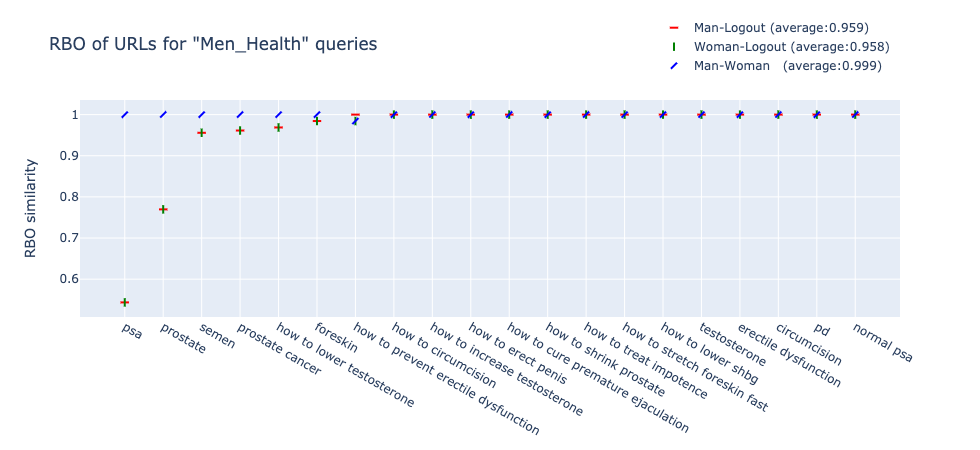

In [664]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average, 'URLs'],
     metrics='RBO',
     category="Men_Health")

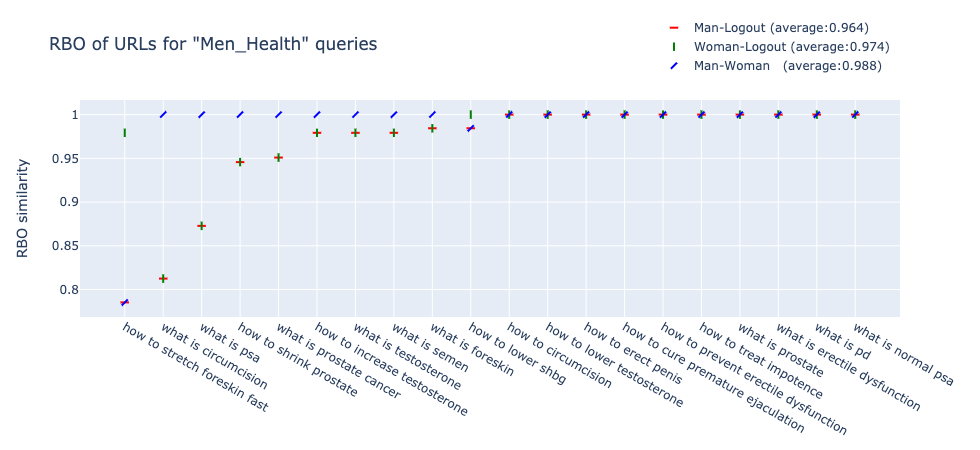

In [462]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average, 'URLs'],
     metrics='RBO',
     category="Men_Health")

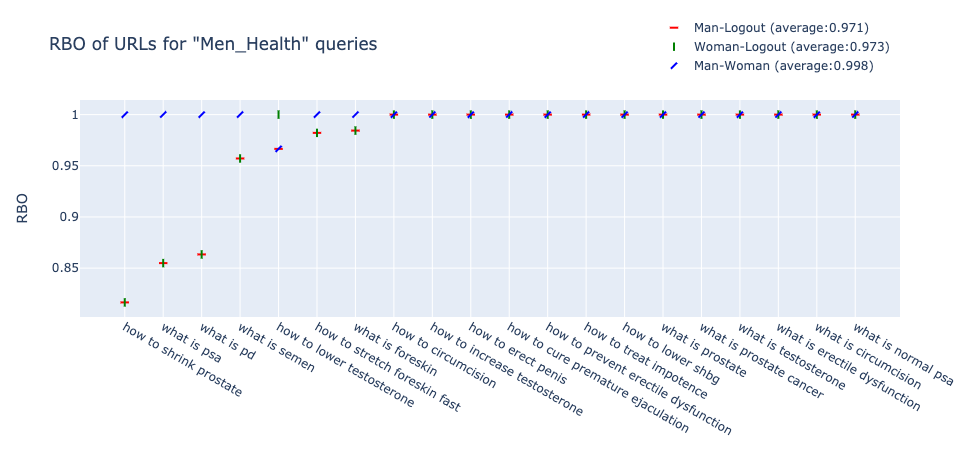

In [383]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average, 'URLs'],
     metrics='RBO',
     category="Men_Health")

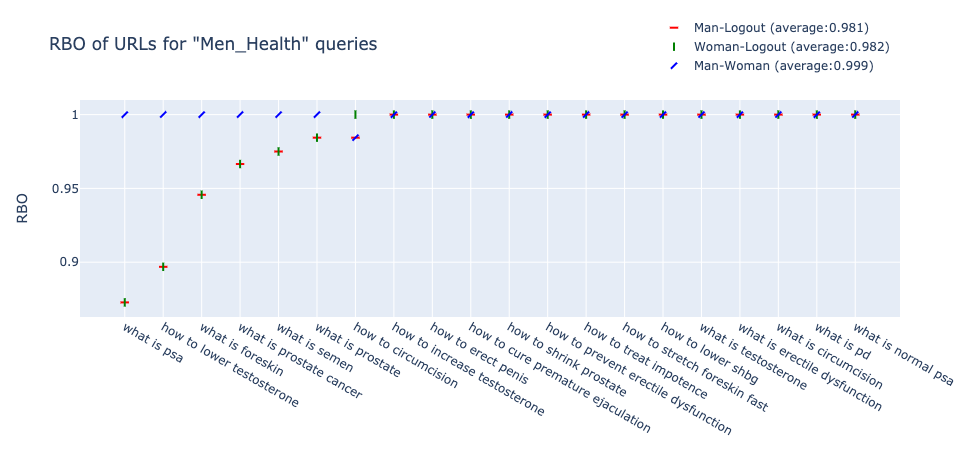

In [411]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average, 'URLs'],
     metrics='RBO',
     category="Men_Health")

In [418]:
res_man, res_woman, res_man_woman, average = CalculatePersonalization(data=[all_queries, logout_google_male, man_google_male, woman_google_male], 
                               metrics=KENDAL, 
                               category='Men_Health' )

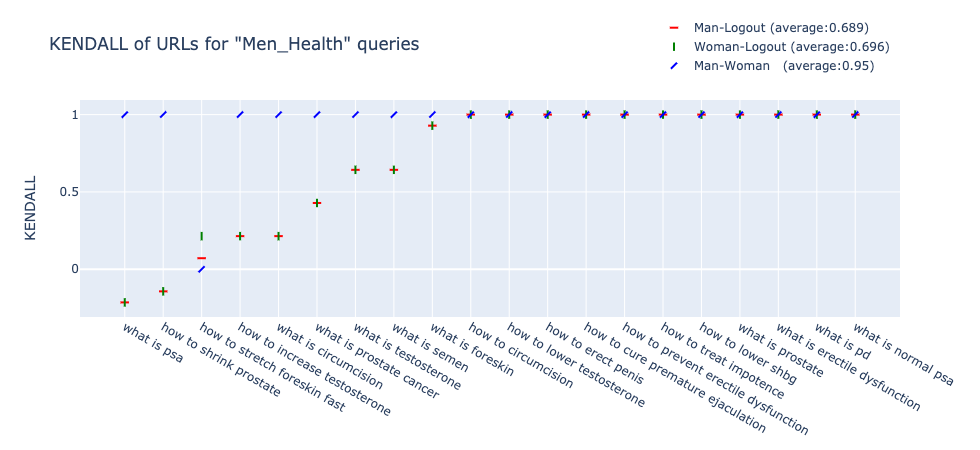

In [419]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average, 'URLs'],
     metrics='KENDALL',
     category="Men_Health")

In [449]:
res_man, res_woman, res_man_woman, average = CalculatePersonalization(data=[all_queries, logout_google_male, man_google_male, woman_google_male], 
                               metrics=JACCARD, 
                               category='Men_Health')


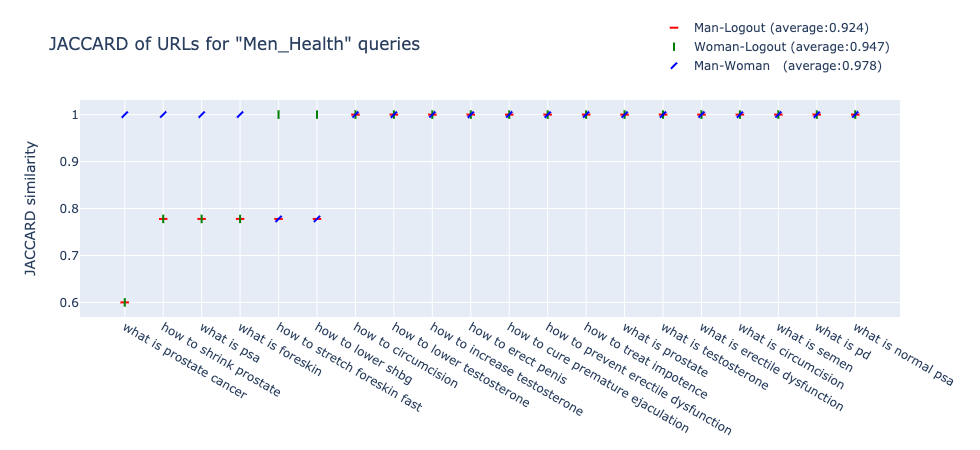

In [450]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average, 'URLs'],
     metrics='JACCARD',
     category="Men_Health")

In [665]:
list(logout_google_male.loc[:,'psa'])

['https://www.groupe-psa.com/en/',
 'https://fr.wikipedia.org/wiki/Groupe_PSA',
 'https://www.motoring.com.au/holden-commodore-and-astra-safe-psa-120403/',
 'https://fr.wikipedia.org/wiki/Groupe_PSA',
 'https://www.usinenouvelle.com/psa/',
 'http://b2b.psa-peugeot-citroen.com/Pages/fr-FR/Home.aspx',
 'https://www.psa-retail.com/fr/',
 'https://www.20minutes.fr/economie/psa/']

In [666]:
list(man_google_male.loc[:,'psa'])

['https://www.groupe-psa.com/en/',
 'https://www.acronymfinder.com/Peugeot-Soci%C3%A9t%C3%A9-Anonyme-(French-company%2Fmanufacturer-of-Peugeot-and-Citroen-vehicles)-(PSA).html',
 'https://en.wikipedia.org/wiki/Groupe_PSA',
 'https://www.motoring.com.au/holden-commodore-and-astra-safe-psa-120403/',
 'https://fr.wikipedia.org/wiki/Opel',
 'http://b2b.psa-peugeot-citroen.com/Pages/fr-FR/Home.aspx',
 'https://www.psa-retail.com/fr/',
 'https://www.20minutes.fr/economie/psa/']

In [667]:
list(woman_google_male.loc[:,'psa'])

['https://www.groupe-psa.com/en/',
 'https://www.acronymfinder.com/Peugeot-Soci%C3%A9t%C3%A9-Anonyme-(French-company%2Fmanufacturer-of-Peugeot-and-Citroen-vehicles)-(PSA).html',
 'https://en.wikipedia.org/wiki/Groupe_PSA',
 'https://www.motoring.com.au/holden-commodore-and-astra-safe-psa-120403/',
 'https://fr.wikipedia.org/wiki/Opel',
 'http://b2b.psa-peugeot-citroen.com/Pages/fr-FR/Home.aspx',
 'https://www.psa-retail.com/fr/',
 'https://www.20minutes.fr/economie/psa/']

## "Women's Health" queries

In [473]:
logout_google_female = pd.read_csv('../Results/Logout/Control__Women_Health.csv', sep=',') 

man_google_female = pd.read_csv('../Results/Login/Man/Google__Women_Health.csv', sep=',')

woman_google_female = pd.read_csv('../Results/Login/Woman/Google__Women_Health.csv', sep=',') 

all_queries = pd.read_csv('../Data/queries2019_20_5.csv', sep=';')

In [522]:
res_man, res_woman, res_man_woman, average = CalculatePersonalization(data=[all_queries, logout_google_female, man_google_female, woman_google_female], 
                               metrics=KENDAL, 
                               category='Women_Health')

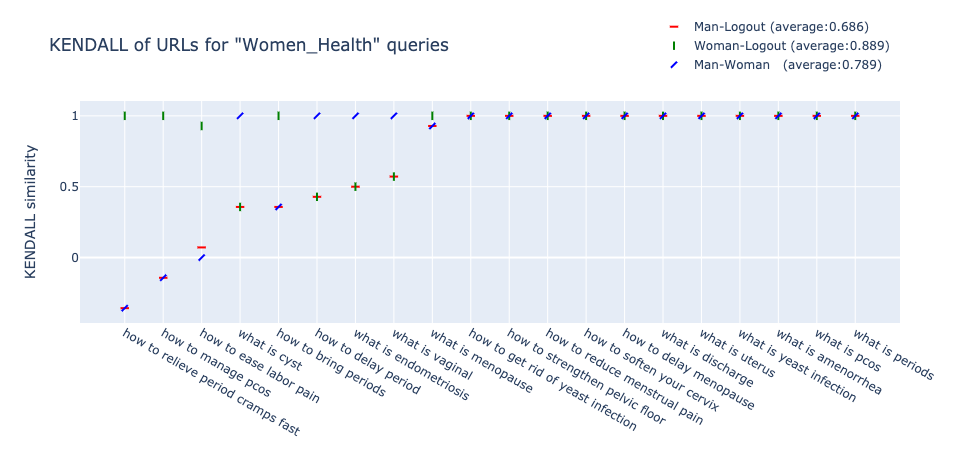

In [523]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average,'URLs'],
     metrics='KENDALL',
     category="Women_Health")

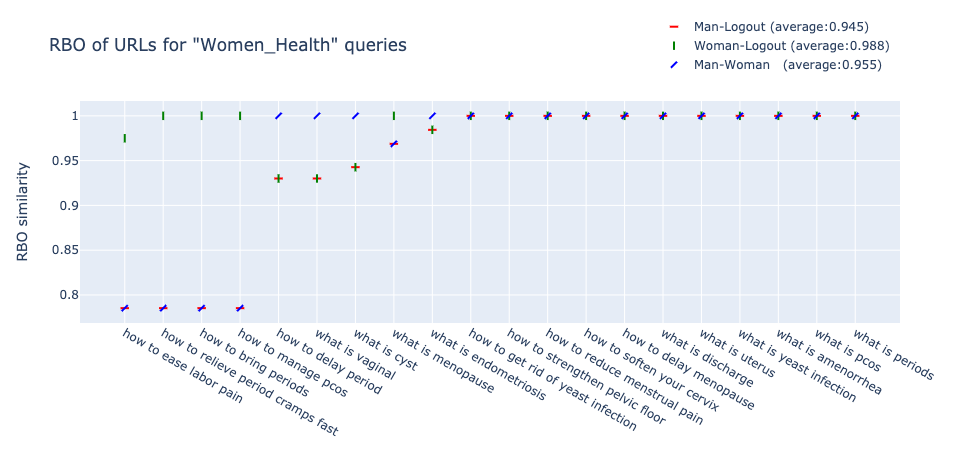

In [491]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average,'URLs'],
     metrics='RBO',
     category="Women_Health")

In [454]:
res_man, res_woman, res_man_woman, average = CalculatePersonalization(data=[all_queries, logout_google_female, man_google_female, woman_google_female], 
                               metrics=RBO, 
                               category='Women_Health')

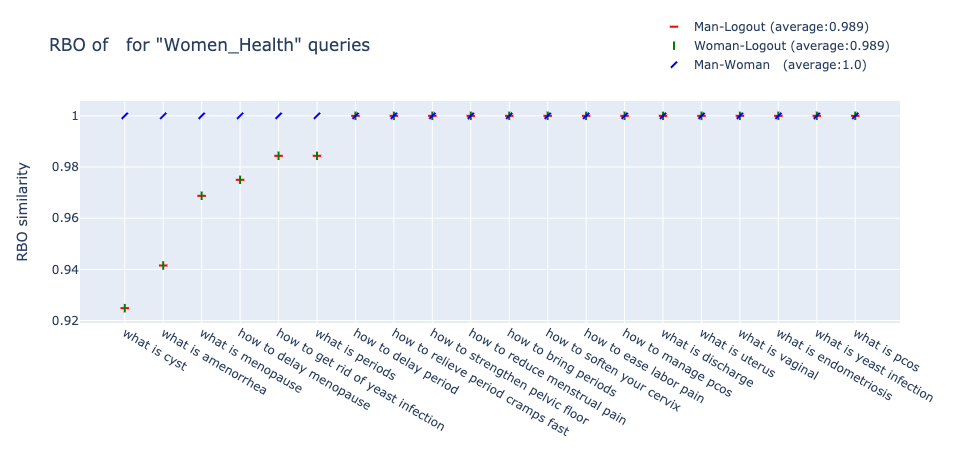

In [456]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average,' '],
     metrics='RBO',
     category="Women_Health")

## "Nutrition" queries

In [487]:
logout_google_nutrition = pd.read_csv('../Results/Logout/Google__Nutrition.csv', sep=',') 

man_google_nutrition = pd.read_csv('../Results/Login/Man/Google__Nutrition.csv', sep=',')

woman_google_nutrition = pd.read_csv('../Results/Login/Woman/Google__Nutrition.csv', sep=',') 

all_queries = pd.read_csv('../Data/queries2019_20_5.csv', sep=';')

In [492]:
res_man, res_woman, res_man_woman, average = CalculatePersonalization(data=[all_queries, logout_google_nutrition, man_google_nutrition, woman_google_nutrition], 
                               metrics=RBO, 
                               category='Nutrition')

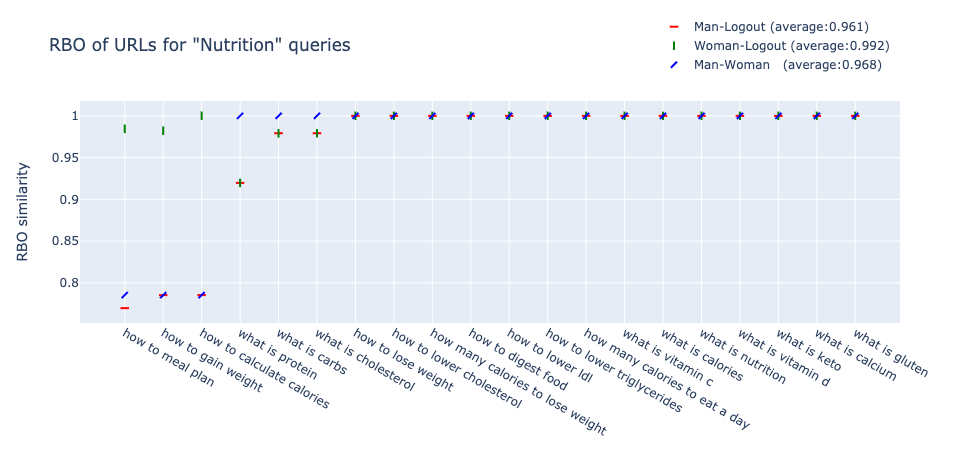

In [493]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average, 'URLs'],
     metrics='RBO',
     category="Nutrition")

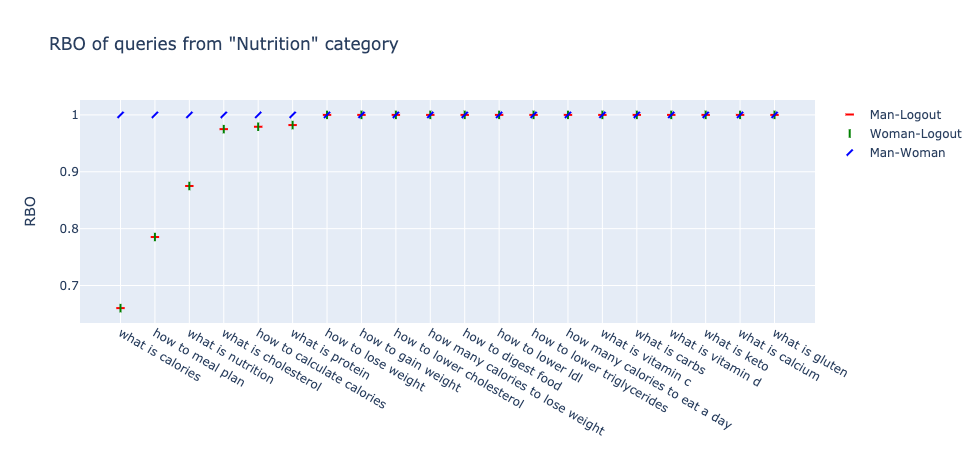

## "Health Conditions" queries

In [494]:
logout_google_health = pd.read_csv('../Results/Logout/Google__Health_Conditions.csv', sep=',') 
#logout_control_health = pd.read_csv('../Results/Logout/ControlHealth.csv', sep=',') 

man_google_health = pd.read_csv('../Results/Login/Man/Google__Health_Conditions.csv', sep=',')
#man_control_health = pd.read_csv('../Results/Login/Man/ControlHealth.csv', sep=',')

woman_google_health = pd.read_csv('../Results/Login/Woman/Google__Health_Conditions.csv', sep=',') 
#woman_control_health = pd.read_csv('../Results/Login/Woman/ControlHealth.csv', sep=',') 

all_queries = pd.read_csv('../Data/queries2019_20_5.csv', sep=';')

In [495]:
res_man, res_woman, res_man_woman, average = CalculatePersonalization(data=[all_queries, logout_google_health, man_google_health, woman_google_health], 
                               metrics=RBO, 
                               category='Health_Conditions')

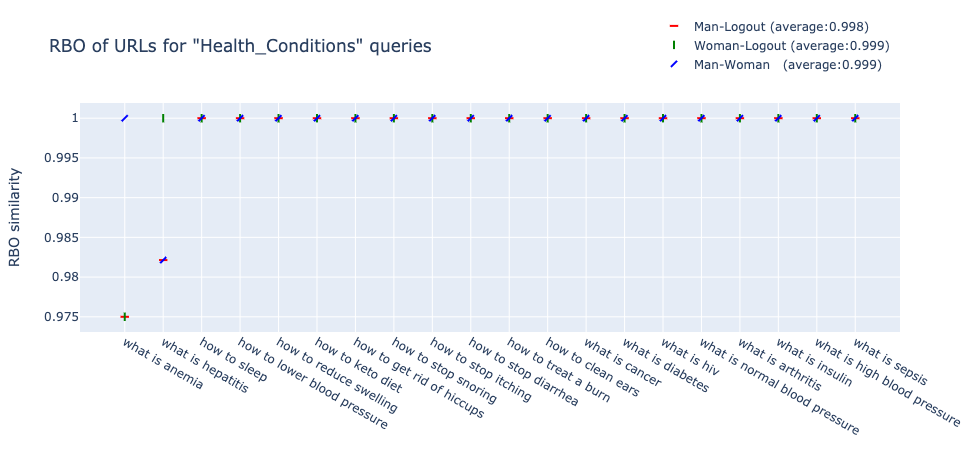

In [496]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average, 'URLs'],
     metrics='RBO',
     category="Health_Conditions")

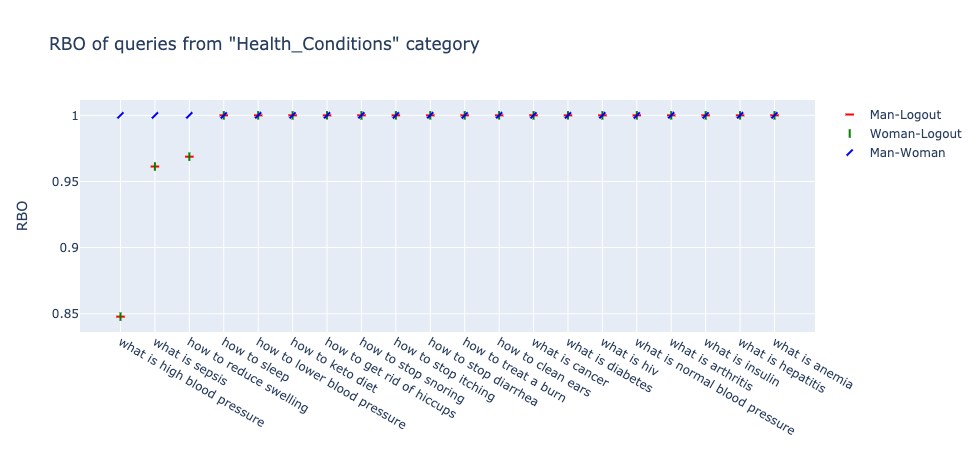

## "Pharmacy" queries

In [497]:
logout_google_pharmacy = pd.read_csv('../Results/Logout/Google__Pharmacy.csv', sep=',') 
#logout_control_pharmacy = pd.read_csv('../Results/Logout/ControlPharmacy.csv', sep=',') 

man_google_pharmacy = pd.read_csv('../Results/Login/Man/Google__Pharmacy.csv', sep=',')
#man_control_pharmacy = pd.read_csv('../Results/Login/Man/ControlPharmacy.csv', sep=',')

woman_google_pharmacy = pd.read_csv('../Results/Login/Woman/Google__Pharmacy.csv', sep=',') 
#woman_control_pharmacy = pd.read_csv('../Results/Login/Woman/ControlPharmacy.csv', sep=',') 

all_queries = pd.read_csv('../Data/queries2019_20_5.csv', sep=';')

In [498]:
res_man, res_woman, res_man_woman, average  = CalculatePersonalization(data=[all_queries, logout_google_pharmacy, man_google_pharmacy, woman_google_pharmacy], 
                               metrics=RBO, 
                               category='Pharmacy')

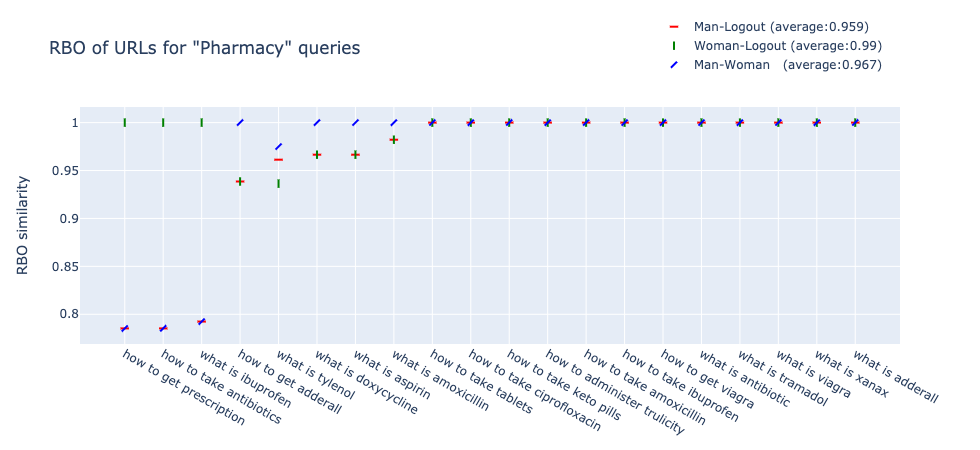

In [499]:
Plot(data=[all_queries, res_man, res_woman, res_man_woman, average, 'URLs'],
     metrics='RBO',
     category="Pharmacy")

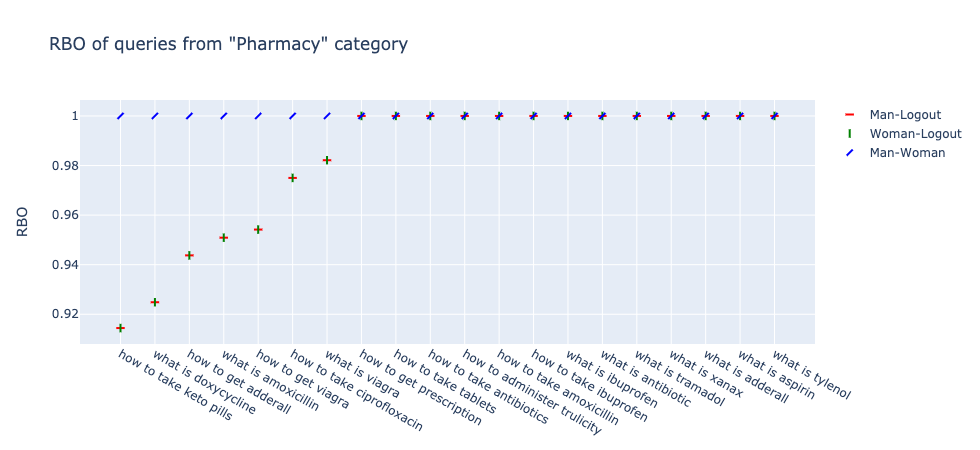

# Fairness analysis

## "Men's Health" queries

In [500]:
res_man, res_woman, res_logout, average = CalculateFairness(data=[all_queries, logout_google_male, man_google_male, woman_google_male], 
                               metrics='Count', 
                               category='Men_Health')

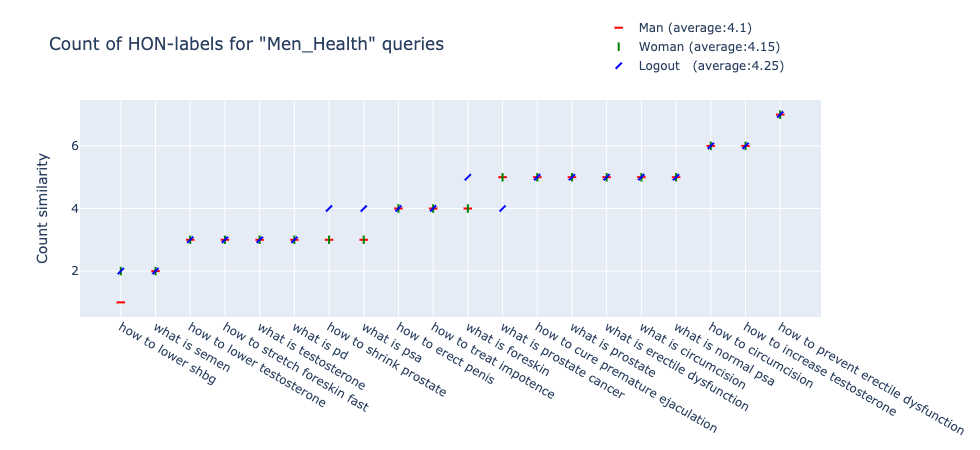

In [501]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='Count',
     category="Men_Health")

In [502]:
res_man, res_woman, res_logout, average = CalculateFairness(data=[all_queries, logout_google_male, man_google_male, woman_google_male], 
                               metrics='RBO', 
                               category='Men_Health')

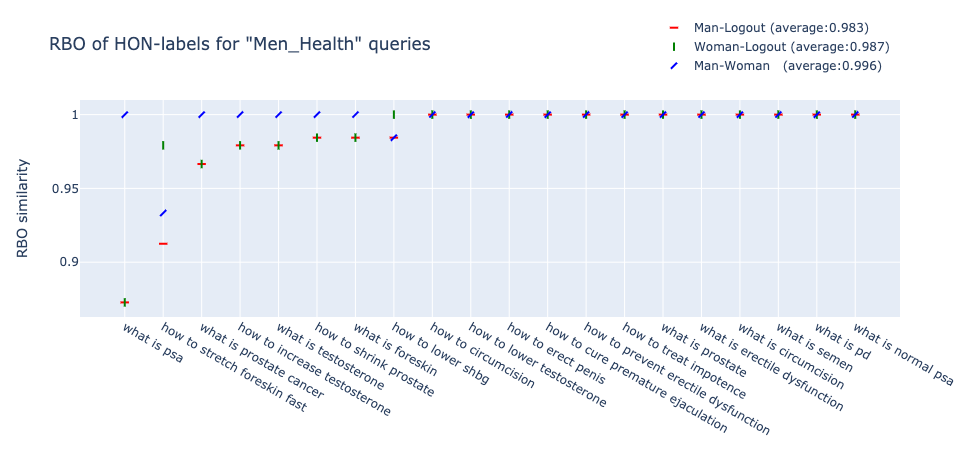

In [503]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='RBO',
     category="Men_Health")

In [276]:
list1 = logout_google_male.loc[:,'Validation: '+'what is pd'].fillna('NOT certified')
indices1 = []
for i, j in enumerate(list1.index[list1 == 'HONcode certified'].tolist()):
    indices1.insert(j, i)
for i, j in enumerate(list1.index[list1 == 'NOT certified'].tolist()):
    indices1.insert(j, i)
list(np.asarray(list(map(str,indices1)))+np.asarray(' '+list1))

['0 HONcode certified',
 '0 NOT certified',
 '1 HONcode certified',
 '1 NOT certified',
 '2 NOT certified',
 '3 NOT certified',
 '4 NOT certified',
 '2 HONcode certified']

In [280]:
list1 = man_google_male.loc[:,'Validation: '+'what is pd'].fillna('NOT certified')
indices1 = []
for i, j in enumerate(list1.index[list1 == 'HONcode certified'].tolist()):
    indices1.insert(j, i)
for i, j in enumerate(list1.index[list1 == 'NOT certified'].tolist()):
    indices1.insert(j, i)
list(np.asarray(list(map(str,indices1)))+np.asarray(' '+list1))

['0 HONcode certified',
 '1 HONcode certified',
 '0 NOT certified',
 '1 NOT certified',
 '2 NOT certified',
 '3 NOT certified',
 '2 HONcode certified',
 '4 NOT certified']

## "Women's Health" queries

In [504]:
res_man, res_woman, res_logout, average = CalculateFairness(data=[all_queries, logout_google_female, man_google_female, woman_google_female], 
                               metrics='Count', 
                               category='Women_Health')

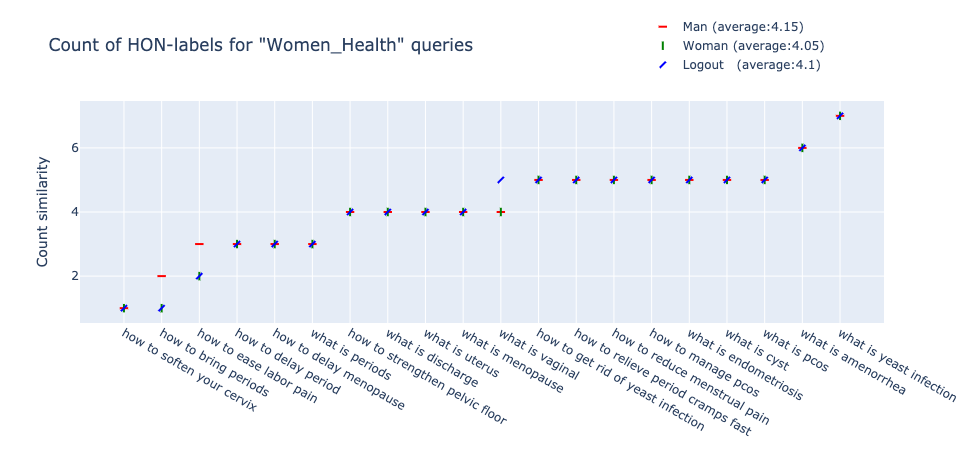

In [505]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='Count',
     category="Women_Health")

In [506]:
res_man, res_woman, res_logout, average = CalculateFairness(data=[all_queries, logout_google_female, man_google_female, woman_google_female], 
                               metrics='RBO', 
                               category='Women_Health')

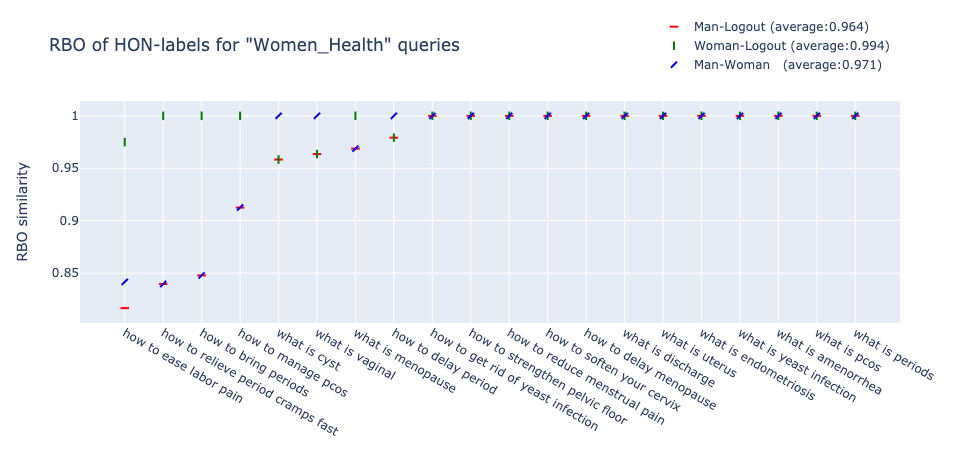

In [508]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='RBO',
     category="Women_Health")

## "Nutrition" queries


In [517]:
res_man, res_woman, res_logout, average = CalculateFairness(data=[all_queries, logout_google_nutrition, man_google_nutrition, woman_google_nutrition], 
                               metrics='Count', 
                               category='Nutrition')

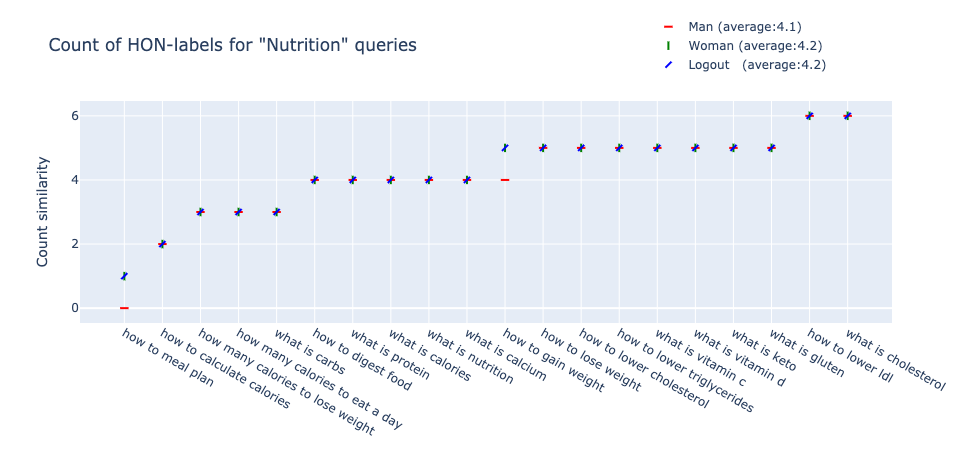

In [518]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='Count',
     category="Nutrition")

In [519]:
res_man, res_woman, res_logout, average = CalculateFairness(data=[all_queries, logout_google_nutrition, man_google_nutrition, woman_google_nutrition], 
                               metrics='RBO', 
                               category='Nutrition')

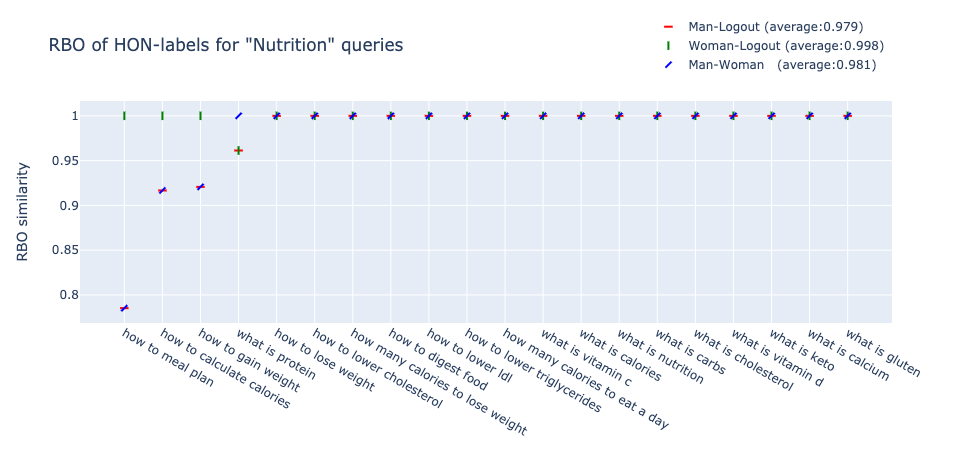

In [520]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='RBO',
     category="Nutrition")

## "Health Conditions" queries

In [515]:
res_man, res_woman, res_logout, average = CalculateFairness(data=[all_queries, logout_google_health, man_google_health, woman_google_health], 
                               metrics='Count', 
                               category='Health_Conditions')

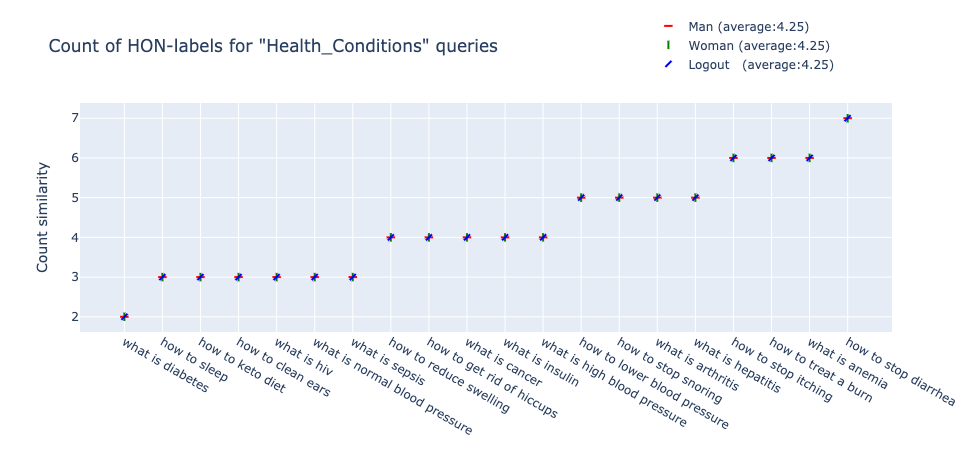

In [516]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='Count',
     category="Health_Conditions")

In [509]:
res_man, res_woman, res_logout, average = CalculateFairness(data=[all_queries, logout_google_health, man_google_health, woman_google_health], 
                               metrics='RBO', 
                               category='Health_Conditions')

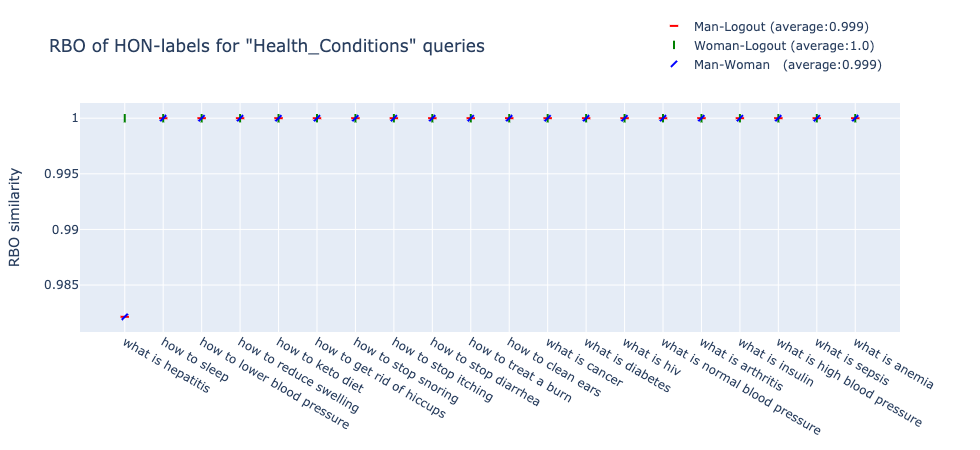

In [510]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='RBO',
     category="Health_Conditions")

## "Pharmacy" queries

In [511]:
res_man, res_woman, res_logout, average  = CalculateFairness(data=[all_queries, logout_google_pharmacy, man_google_pharmacy, woman_google_pharmacy], 
                               metrics='Count', 
                               category='Pharmacy')

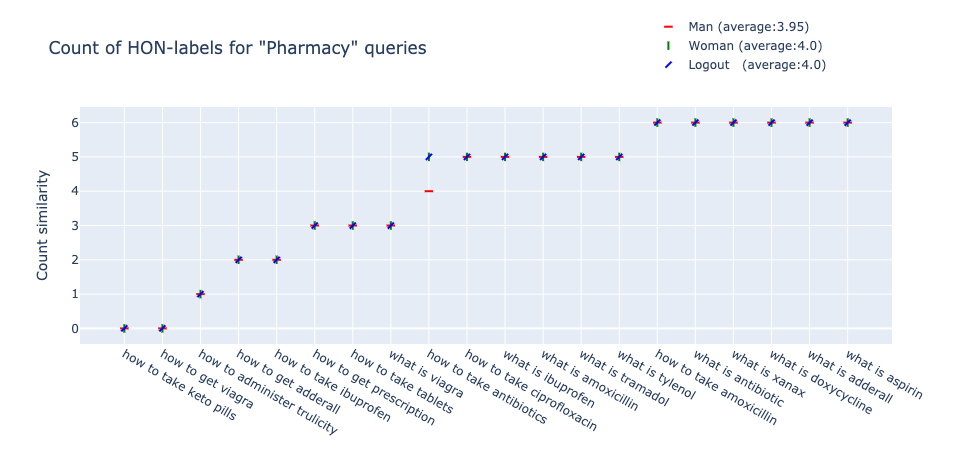

In [512]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='Count',
     category="Pharmacy")

In [513]:
res_man, res_woman, res_logout, average  = CalculateFairness(data=[all_queries, logout_google_pharmacy, man_google_pharmacy, woman_google_pharmacy], 
                               metrics='RBO', 
                               category='Pharmacy')

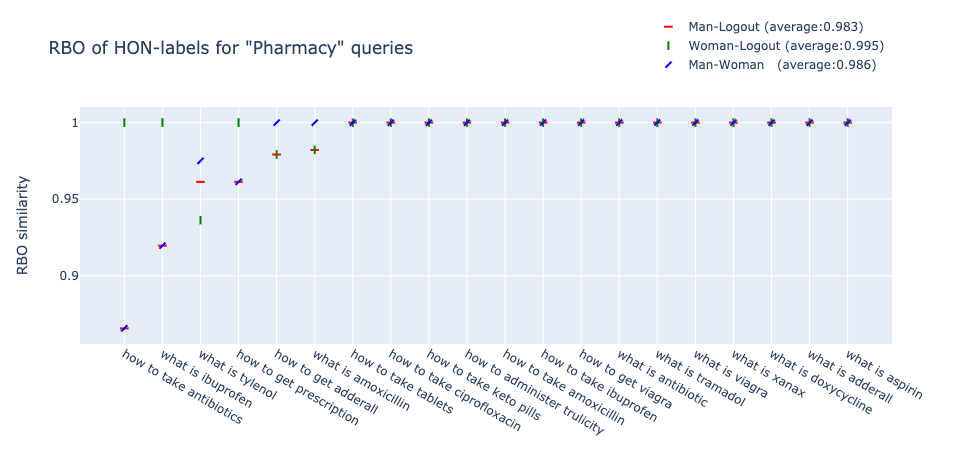

In [514]:
Plot(data=[all_queries, res_man, res_woman, res_logout, average, 'HON-labels'],
     metrics='RBO',
     category="Pharmacy")